In [1]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns 
import h5py

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix 
from tensorflow.keras.models import load_model

In [3]:
# Display images using OpenCV
from google.colab.patches import cv2_imshow

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
data_dir = "/content/drive/MyDrive/NEW DATASET WASTE/DATASET"
os.listdir(data_dir)

['TEST', 'TRAIN', '.ipynb_checkpoints']

In [6]:
# Define the directory paths for the training and testing sets
train_d = '/content/drive/MyDrive/NEW DATASET WASTE/DATASET/TRAIN'
test_d= '/content/drive/MyDrive/NEW DATASET WASTE/DATASET/TEST'

In [7]:
# sanity check to view the size/dimension of the images

def checkImageSize(dir, category):
  cat_path = os.path.join(dir, category)
  imgs = os.listdir(cat_path)

  for i in range (5):
    img = imgs[i]
    image = cv2.imread(os.path.join(cat_path, img))
    print(image.shape)

In [8]:
def resize_images(data_dir, target_size):
    train_dir = os.path.join(data_dir, 'TRAIN')
    test_dir = os.path.join(data_dir, 'TEST')
    
    for folder in ['O', 'R']:
        # Resize train images
        train_folder = os.path.join(train_dir, folder)
        for filename in os.listdir(train_folder):
            img_path = os.path.join(train_folder, filename)
            img = cv2.imread(img_path)
            resized_img = cv2.resize(img, target_size)
            cv2.imwrite(img_path, resized_img)
            
        # Resize test images
        test_folder = os.path.join(test_dir, folder)
        for filename in os.listdir(test_folder):
            img_path = os.path.join(test_folder, filename)
            img = cv2.imread(img_path)
            resized_img = cv2.resize(img, target_size)
            cv2.imwrite(img_path, resized_img)

In [9]:
target_size = (64,64)
batch_size = 32

In [12]:
resize_images(data_dir, (target_size))   # resizing the images 

In [13]:
checkImageSize(test_d, 'O')
checkImageSize(train_d, 'R')

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


In [15]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [16]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [17]:
# Create the image data generators for the training and testing sets
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)

In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [46]:
# Define the CNN model architecture
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu',padding= "same",input_shape=(64,64,3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu',padding= "same"))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [47]:
# To check the model summary

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                      

In [48]:
# Compile the model
model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])

In [49]:
# Defining the early stopping layer
# We need to state what we are monitoring for early stopping
# If am monitoring val_loss then mode will be "min" and if val_accuracy then mode will be "max"
# Patience , how many epochs do i want it to run before it stops
from tensorflow.keras.callbacks import EarlyStopping
es= EarlyStopping(monitor = "val_loss", patience =3, verbose =2, mode ="min")

In [51]:
# Defining checkpoint(ck) to save the best model
from tensorflow.keras.callbacks import ModelCheckpoint
ck = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/WASTE IDENTIFICATION/waste_model.h5", monitor = "val_loss", save_best_only=True, save_weights_only=True)

In [52]:
# to create the training and test batch of images
train_generator = train_datagen.flow_from_directory(train_d,target_size,batch_size=batch_size,class_mode='binary')

Found 12034 images belonging to 2 classes.


In [53]:
test_generator = test_datagen.flow_from_directory(test_d,target_size,batch_size=batch_size,class_mode='binary')

Found 2513 images belonging to 2 classes.


# Fitting the model on the train data

In [54]:
# Training the model
history = model.fit(train_generator,steps_per_epoch=train_generator.n // batch_size,epochs=10,validation_data=test_generator,validation_steps=test_generator.n // batch_size, callbacks=[es,ck])

Epoch 1/10
376/376 [==============================] - 53s 125ms/step - loss: 0.7129 - accuracy: 0.7511 - val_loss: 0.8714 - val_accuracy: 0.4479
Epoch 2/10
376/376 [==============================] - 41s 110ms/step - loss: 0.4682 - accuracy: 0.7716 - val_loss: 0.5429 - val_accuracy: 0.7139
Epoch 3/10
376/376 [==============================] - 40s 108ms/step - loss: 0.4504 - accuracy: 0.7527 - val_loss: 0.5091 - val_accuracy: 0.7043
Epoch 4/10
376/376 [==============================] - 41s 109ms/step - loss: 0.4227 - accuracy: 0.7878 - val_loss: 0.4584 - val_accuracy: 0.7800
Epoch 5/10
376/376 [==============================] - 43s 116ms/step - loss: 0.4203 - accuracy: 0.7980 - val_loss: 0.6652 - val_accuracy: 0.6807
Epoch 6/10
376/376 [==============================] - 43s 114ms/step - loss: 0.4100 - accuracy: 0.8030 - val_loss: 0.4675 - val_accuracy: 0.8065
Epoch 7/10
376/376 [==============================] - 47s 124ms/step - loss: 0.3941 - accuracy: 0.8426 - val_loss: 0.3465 - val_ac

# First Model Evaluation

In [55]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')


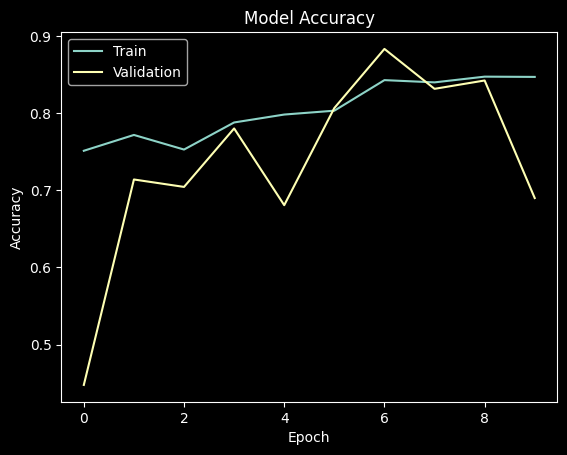

In [56]:
# plotting the model graph based on accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# From the accuracy graph, the model perfomed well from inception however, it started overfitting at the fifth epoch which implies that the model is not generalizing well. Early stopping was used as call back so as to stop the epoch once the model's performance is not improving. As a result of this i will modify the model's parameter to combat overfitting in the first model. e.g reducing the number of layers, reducing the number of neurons, using data augementation, use dropout and regularization.

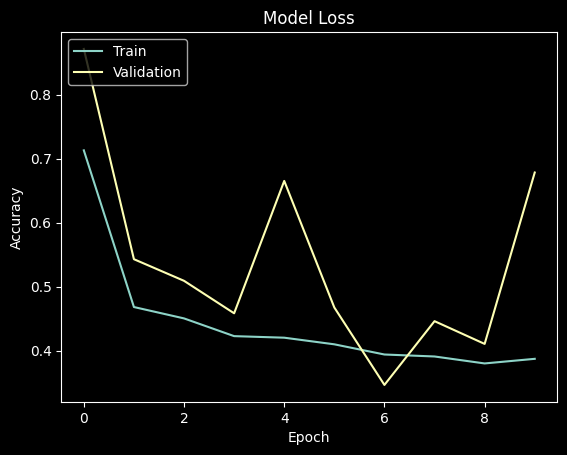

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Observations
- The model generalized well on the data
- The traingi stopped at the 5th epoch due to the call back used(early stopping)

In [58]:
# Evaluating the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

79/79 [==============================] - 5s 57ms/step - loss: 0.6806 - accuracy: 0.6896
Test accuracy: 0.6896139979362488


In [59]:
# Get the true classes for the test set
y_true = test_generator.classes

In [60]:
y_true.shape

(2513,)

In [61]:
num_classes = len(np.unique(y_true))
print(num_classes)

2


In [62]:
# Get the predicted classes for the test set
y_pred = model.predict(test_generator)
# y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes = [1 if y_true>0.5 else 0 for y_true in y_pred]
# pred1 =[1 if pred>0.5 else 0 for pred in pred1]

79/79 [==============================] - 6s 81ms/step


In [63]:
y_true

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [64]:
# to print classification report
from sklearn import metrics
from sklearn.metrics import classification_report
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
report = metrics.classification_report(true_classes, y_pred_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           O       0.55      0.85      0.67      1401
           R       0.42      0.14      0.21      1112

    accuracy                           0.54      2513
   macro avg       0.49      0.49      0.44      2513
weighted avg       0.50      0.54      0.47      2513



In [65]:
# # Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

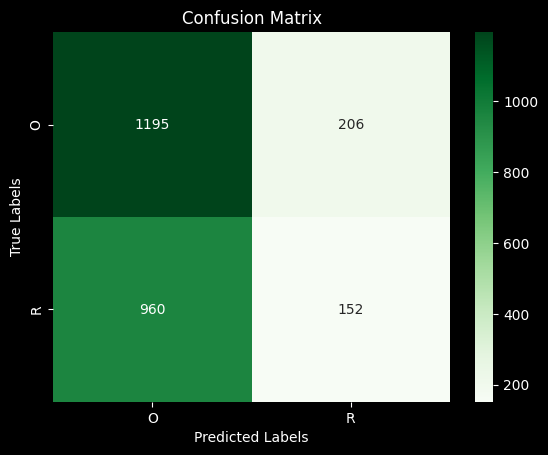

In [66]:
# Creating the heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)

# Set plot properties
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()  

# Using Data Augumentation

In [67]:
# Clearing backend sessions
from tensorflow.keras import backend
backend.clear_session()

# Setting the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [68]:
# Rescaling all images by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=180, 
                              fill_mode='nearest',
                              horizontal_flip = True,
                              vertical_flip = True,
                              shear_range = 0.2,
                              zoom_range = 0.2
                              )
test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

In [72]:
# Initializing a sequential Model
model = Sequential()

# Adding the first conv layer with 128 filters and kernels size 3X3
model.add(Conv2D(128, (3, 3), activation='relu', padding="same",input_shape=(64,64,3))) 
# Adding maxpooling to reduce thw size of the output of the first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 120 neurons    
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.5))
 
model.add(Dense(1, activation='sigmoid'))
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                      

In [73]:
batch_size = 64

In [74]:
# Training our model
history_1 = model.fit(train_generator,steps_per_epoch=train_generator.n // batch_size,epochs=10,validation_data=test_generator,validation_steps=test_generator.n // batch_size, callbacks=[es,ck])

Epoch 1/10
188/188 [==============================] - 24s 111ms/step - loss: 0.5882 - accuracy: 0.7526 - val_loss: 0.6478 - val_accuracy: 0.5857
Epoch 2/10
188/188 [==============================] - 20s 106ms/step - loss: 0.4717 - accuracy: 0.7915 - val_loss: 0.4833 - val_accuracy: 0.8221
Epoch 3/10
188/188 [==============================] - 21s 112ms/step - loss: 0.4712 - accuracy: 0.7922 - val_loss: 0.5001 - val_accuracy: 0.8029
Epoch 4/10
188/188 [==============================] - 21s 110ms/step - loss: 0.4674 - accuracy: 0.7911 - val_loss: 0.8582 - val_accuracy: 0.6066
Epoch 5/10
188/188 [==============================] - 21s 109ms/step - loss: 0.4516 - accuracy: 0.7999 - val_loss: 0.8470 - val_accuracy: 0.6803
Epoch 5: early stopping


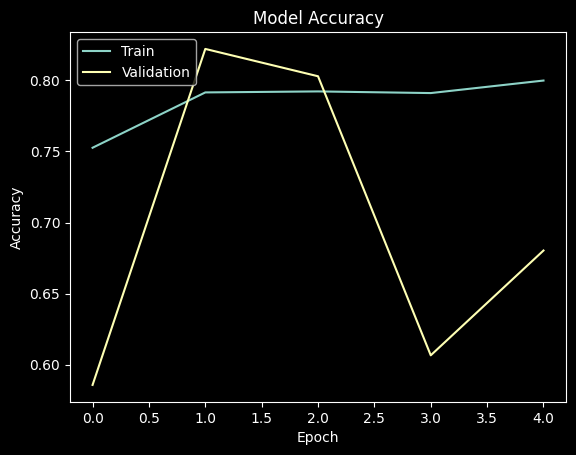

In [75]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

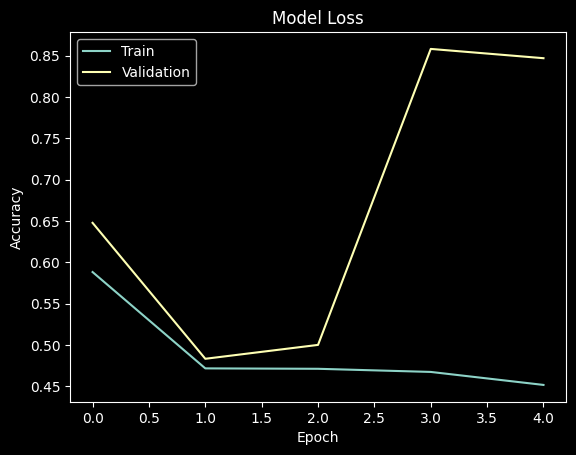

In [76]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Obsrevations
- With the data augumentation, the model performed well when applied on the    train set compared to the base model and with good accuracy score.
- Data Augumentation was not applied on the test dataset.

# Using Transfer Learning VGG16

With the use of VGG16 which is a pretrained model, that has been trained on the ImageNet dataset.To train VGG16, the convolutional and pooling layers will be used directly and their weights will be freezed. Which implies no training will be done on the weights. To classify, the exisiting fully connected layers will be replaced with the fully connected layers created for this classification. The include_top parameter will be set to false. The input shape will be the model's dimension and not the default 224 by 224.

In [77]:
# importing the necessary libraries for VGG16

from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

vgg16_model = VGG16(weights="imagenet", include_top = False, input_shape= (64,64,3))
vgg16_model.summary()


58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [78]:
# To freeze the layers i.e making all the VGG model layers non-trainable.
for layer in vgg16_model.layers:
    layer.trainable = False

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [80]:
model_new1 = Sequential()
# Adding the convolutional layer of the initial VGG16 model
model_new1.add(vgg16_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_new1.add(Flatten())

# Adding a dense output layer
model_new1.add(Dense(64, activation='relu'))
model_new1.add(Dropout(0.2))
model_new1.add(Dense(32, activation='relu'))
model_new1.add(Dense(1, activation='softmax'))
opt=Adam()
# Compiling the model
model_new1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model_new1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                131136    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,847,937
Trainable params: 133,249
Non

In [81]:
# defining the epochs and batch size

epochs = 10
Batch_size = 64

# Second Model Training

In [82]:
new_vgg16 = model_new1.fit(train_generator,steps_per_epoch=train_generator.n // Batch_size,epochs=10,validation_data=test_generator,validation_steps=test_generator.n // Batch_size, callbacks=[es], verbose =1)

Epoch 1/10
188/188 [==============================] - 23s 112ms/step - loss: 0.0000e+00 - accuracy: 0.3132 - val_loss: 0.0000e+00 - val_accuracy: 0.4359
Epoch 2/10
188/188 [==============================] - 21s 111ms/step - loss: 0.0000e+00 - accuracy: 0.3169 - val_loss: 0.0000e+00 - val_accuracy: 0.4487
Epoch 3/10
188/188 [==============================] - 20s 109ms/step - loss: 0.0000e+00 - accuracy: 0.3177 - val_loss: 0.0000e+00 - val_accuracy: 0.4279
Epoch 4/10
188/188 [==============================] - 21s 111ms/step - loss: 0.0000e+00 - accuracy: 0.3163 - val_loss: 0.0000e+00 - val_accuracy: 0.4471
Epoch 4: early stopping


In [ ]:
# To delete the existing model
# del model


In [ ]:
# load weights into new model
# model.load_weights("/content/drive/MyDrive/Colab Notebooks/WASTE IMAGE MODEL/waste_model.h5")

In [ ]:
# To create a HDF5 file
model.save("/content/drive/MyDrive/Colab Notebooks/WASTE IMAGE MODEL/waste_model.h5") 

In [ ]:
# model = load_model("./content/drive/MyDrive/Colab Notebooks/WASTE IMAGE MODEL/waste_model.h5")

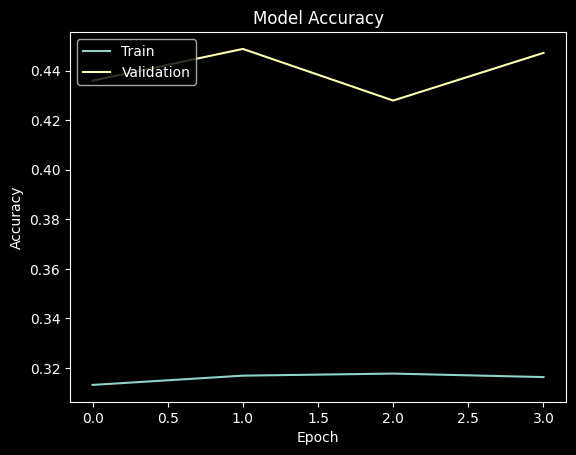

In [84]:
plt.plot(new_vgg16.history['accuracy'])
plt.plot(new_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The model generalized well with our transfer learning vgg16 


In [85]:
# Evaluating the model on the test data
test_loss_1, test_acc_1 = model_new1.evaluate(test_generator)

# Display the classification accuracy
print('Test accuracy1:', test_acc_1)

79/79 [==============================] - 5s 58ms/step - loss: 0.0000e+00 - accuracy: 0.4425
Test accuracy1: 0.4424990117549896


In [86]:
# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_d,target_size,batch_size=batch_size,class_mode='categorical')
#     'test_dir',
#     target_size=input_shape[:2],
#     batch_size=32,
#     class_mode='categorical',
#     classes=['O', 'R']
# )


Found 2513 images belonging to 2 classes.


In [87]:
# Get the true labels
y_true_labels = test_generator.classes

In [ ]:
y_true_labels

In [89]:
y_true_labels.shape

(2513,)

In [ ]:
# # Get the predicted classes for the test set
# y_pred = model.predict(test_generator)
# # y_pred_classes = np.argmax(y_pred, axis=1)
# y_pred_classes = [1 if y_true>0.5 else 0 for y_true in y_pred]
# # pred1 =[1 if pred>0.5 else 0 for pred in pred1]

In [90]:
# Predict on the test data
y_pred1 = model_new1.predict(test_generator)

40/40 [==============================] - 5s 102ms/step


In [94]:
# Convert predictions to class labels
y_pred_labels1 = np.argmax(y_pred1, axis=1)
y_pred_classes_new = [1 if y_true_labels>0.5 else 0 for y_true_labels in y_pred1]
class_labels = ['O', 'R']

In [130]:
# Generate the classification report
report_VGG16 = classification_report(y_true_labels, y_pred_classes_new, target_names=class_labels)

In [131]:
# Print the classification report
print(report_VGG16)

              precision    recall  f1-score   support

           O       0.00      0.00      0.00      1401
           R       0.44      1.00      0.61      1112

    accuracy                           0.44      2513
   macro avg       0.22      0.50      0.31      2513
weighted avg       0.20      0.44      0.27      2513



In [97]:
# # Create confusion matrix
cm1 = confusion_matrix(y_true_labels, y_pred_classes_new)

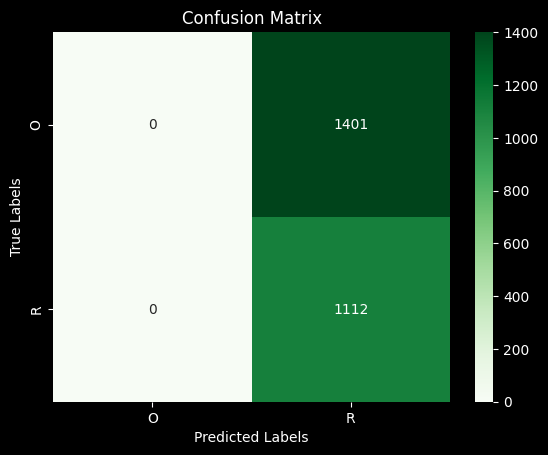

In [98]:
# Creating the heatmap
sns.heatmap(cm1, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)

# Set plot properties
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show() 

In [99]:
# to print classification report
from sklearn import metrics
from sklearn.metrics import classification_report
true_classes_new = test_generator.classes
class_labels_new = list(test_generator.class_indices.keys())
report = metrics.classification_report(true_classes_new, y_pred_classes_new, target_names=class_labels_new)
print(report)

              precision    recall  f1-score   support

           O       0.00      0.00      0.00      1401
           R       0.44      1.00      0.61      1112

    accuracy                           0.44      2513
   macro avg       0.22      0.50      0.31      2513
weighted avg       0.20      0.44      0.27      2513



# Using ResNet50

In [100]:
# Clearing backend sessions
from tensorflow.keras import backend
backend.clear_session()

# Setting the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [101]:
# # Define the input size of the images
tar= (64, 64,3)

In [ ]:
# checkImageSize(test_d, 'O')
# checkImageSize(train_d, 'R')

In [102]:
# Define the number of classes for classification
# num_classes = 2
batch_size=64

In [103]:
# Create a ResNet50 model with pre-trained weights
resnet_model = tf.keras.applications.ResNet50(
    include_top=False, 
    weights='imagenet', 
    input_shape=(64,64,3)
)
resnet_model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                          

In [104]:
# Freeze the pre-trained layers in the model
for layer in resnet_model.layers:
    layer.trainable = False

In [105]:
from keras.layers.serialization import activation
# Add new layers for classification
from keras import layers
#creating instance of the model
model_resnet = Sequential()
 #adding the convolutional layer
model_resnet.add(resnet_model)
 #flat
model_resnet.add(Flatten())

 #adding dense outputlayer
model_resnet.add(Dense(64,activation='relu'))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(32,activation= 'relu'))
model_resnet.add(Dense(1,activation = 'softmax'))
opt=Adam()


In [106]:
model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 24,114,177
Trainable params: 526,465
Non-t

In [107]:
from keras.engine.training import optimizer
model_resnet.compile(optimizer= opt,loss = 'categorical_crossentropy',metrics= ['accuracy'])

In [108]:
# Training the model
history_new = model_resnet.fit(
    train_generator,
    steps_per_epoch=train_generator.n//batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.n//batch_size
)

Epoch 1/10
188/188 [==============================] - 30s 131ms/step - loss: 0.0000e+00 - accuracy: 0.3195 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
188/188 [==============================] - 23s 122ms/step - loss: 0.0000e+00 - accuracy: 0.3165 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/10
188/188 [==============================] - 23s 123ms/step - loss: 0.0000e+00 - accuracy: 0.3223 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/10
188/188 [==============================] - 23s 121ms/step - loss: 0.0000e+00 - accuracy: 0.3109 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/10
188/188 [==============================] - 26s 140ms/step - loss: 0.0000e+00 - accuracy: 0.3159 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/10
188/188 [==============================] - 28s 150ms/step - loss: 0.0000e+00 - accuracy: 0.3193 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/10
188/188 [==============================] - 24s 127ms/step - loss: 0.0000e+00 - accuracy: 0.3153

In [109]:
test_loss_res, test_acc_res = model_resnet.evaluate(test_generator)

print('Test accuracy:', test_acc_res)

40/40 [==============================] - 5s 131ms/step - loss: 0.6931 - accuracy: 0.5000
Test accuracy: 0.5


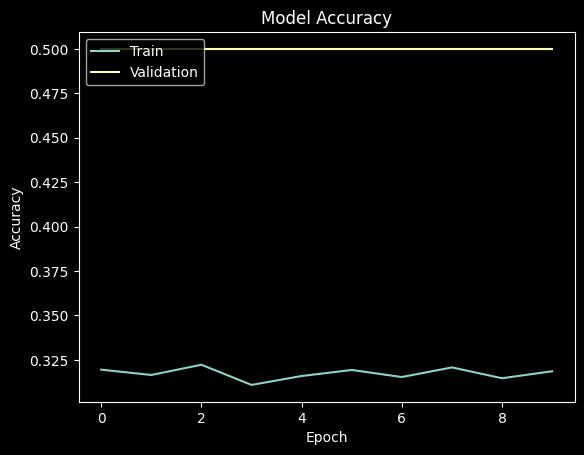

In [111]:
plt.plot(history_new.history['accuracy'])
plt.plot(history_new.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [164]:
# # Get the true classes for the test set
y_true = test_generator.classes

In [165]:
# checking the shape of the target
y_true.shape

(2513,)

In [171]:
# Get the predicted classes for the test set
y_pred_resnet = model_resnet.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=0)
y_pred_classes_res = [1 if y_true>0.5 else 0 for y_true in y_pred_resnet]
# pred1 =[1 if pred>0.5 else 0 for pred in pred1]

40/40 [==============================] - 4s 104ms/step


In [172]:
# to print classification report
from sklearn import metrics
from sklearn.metrics import classification_report
true_classes_res = test_generator.classes
class_labels_res = list(test_generator.class_indices.keys())
report_res = metrics.classification_report(true_classes_res, y_pred_classes_res, target_names=class_labels_res)
print(report_res)

              precision    recall  f1-score   support

           O       0.00      0.00      0.00      1401
           R       0.44      1.00      0.61      1112

    accuracy                           0.44      2513
   macro avg       0.22      0.50      0.31      2513
weighted avg       0.20      0.44      0.27      2513



In [ ]:
# # Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

In [135]:
print(y_pred_resnet.shape)

(2513,)


In [120]:
from sklearn.metrics import roc_auc_score

auc_roc = roc_auc_score(y_true, y_prob[:, 0], multi_class='ovr')

In [121]:
print(auc_roc)

0.5


In [147]:
y_pred_prob = model_resnet.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

40/40 [==============================] - 5s 114ms/step


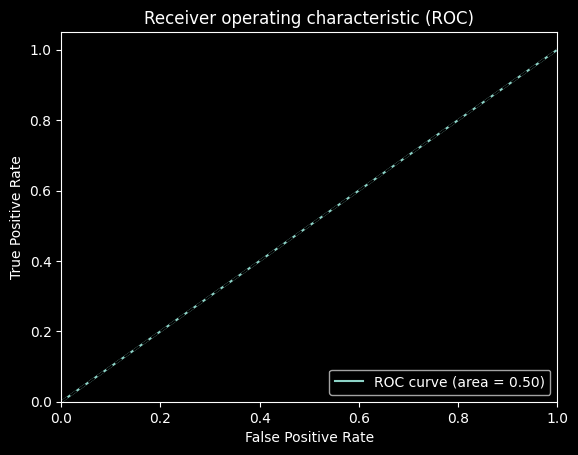

In [157]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_true and y_proba are your true labels and predicted probabilities respectively
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()